In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import math
import datetime
from tensorflow.keras import regularizers
%matplotlib inline

2023-08-07 12:10:05.452925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 12:10:05.684440: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-07 12:10:05.733257: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-07 12:10:05.733298: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [19]:
df=pd.read_csv('min_daily_temp.csv')

In [20]:
df.set_index('Date',inplace=True)

In [21]:
df=df[2500:]

In [22]:
series_1 = df['Temp'].values


In [23]:

per_age = 0.8
shp = series_1.shape

shp_i = per_age*shp[0]
shp_i = math.floor(shp_i) 


In [24]:
x_train = series_1[:shp_i]
x_valid = series_1[shp_i+1:]
#x_valid_1 = series_1[shp_i+1:]
x_valid.shape

(189,)

In [25]:
window_size = 200
batch_size = 8
shuffle_buffer_size = 1

dataset_tr= windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-08-07 12:11:49.548726: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-07 12:11:49.548755: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-07 12:11:49.548773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shahid): /proc/driver/nvidia/version does not exist
2023-08-07 12:11:49.550129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:

### RNN
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(80, return_sequences=True,activation = 'relu'),  
#  tf.keras.layers.SimpleRNN(512, return_sequences=True,kernel_regularizer=regularizers.L2(l2 = 0.1)),
#  tf.keras.layers.SimpleRNN(256, return_sequences=True,kernel_regularizer=regularizers.L2(l2 = 0.1)),  
#  tf.keras.layers.SimpleRNN(128,return_sequences=True,kernel_regularizer=regularizers.L2(l2 = 0.1)),
     
    tf.keras.layers.SimpleRNN(80,return_sequences=True,activation ='relu'),
    
#  tf.keras.layers.SimpleRNN(40,return_sequences=True),  
    tf.keras.layers.SimpleRNN(80,activation ='relu'),
    tf.keras.layers.Dense(1),
#    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 200, 1)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 200, 80)           6560      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 200, 80)           12880     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 80)                12880     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 32,401
Trainable params: 32,401
Non-trainable params: 0
_________________________________________________________________


In [220]:
# l0 = tf.keras.layers.Dense(256, input_shape=[window_size],activation = 'relu',kernel_regularizer=regularizers.L2(l2=0.01))
# l1 = tf.keras.layers.Dense(128,activation = 'relu',kernel_regularizer=regularizers.L2(l2=0.01))
# l7 = tf.keras.layers.Dense(64, activation = 'relu')
# l3 = tf.keras.layers.Dense(32, activation = 'relu')
# l2 = tf.keras.layers.Dense(16, activation = 'relu')
# l4 = tf.keras.layers.Dense(8, activation = 'relu')
# l5 = tf.keras.layers.Dense(4, activation = 'relu')
# l6 = tf.keras.layers.Dense(1,activation ='relu')
# model_1 = tf.keras.models.Sequential([l0,l1,l7,l3,l2,l4,l5,l6])
# print("Layer weights: \n {} \n".format(l0.get_weights()))
# model_1.summary()

# Model

In [28]:
model_1.compile(loss="mape", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [29]:
model_1.fit(dataset_tr,epochs=300)


Epoch 1/300
70/70 [==============================] - 5s 46ms/step - loss: 28.9839
Epoch 2/300
70/70 [==============================] - 3s 44ms/step - loss: 21.8218
Epoch 3/300
70/70 [==============================] - 3s 44ms/step - loss: 20.3533
Epoch 4/300
70/70 [==============================] - 3s 44ms/step - loss: 19.8569
Epoch 5/300
70/70 [==============================] - 3s 44ms/step - loss: 20.3400
Epoch 6/300
70/70 [==============================] - 3s 44ms/step - loss: 19.2544
Epoch 7/300
70/70 [==============================] - 3s 44ms/step - loss: 19.4803
Epoch 8/300
70/70 [==============================] - 3s 43ms/step - loss: 19.6862
Epoch 9/300
70/70 [==============================] - 3s 44ms/step - loss: 19.1642
Epoch 10/300
70/70 [==============================] - 3s 44ms/step - loss: 19.0959
Epoch 11/300
70/70 [==============================] - 3s 44ms/step - loss: 18.6391
Epoch 12/300
70/70 [==============================] - 3s 44ms/step - loss: 18.7458
Epoch 13/300


70/70 [==============================] - 3s 44ms/step - loss: 11.4590
Epoch 100/300
70/70 [==============================] - 3s 44ms/step - loss: 11.3139
Epoch 101/300
70/70 [==============================] - 3s 44ms/step - loss: 10.9134
Epoch 102/300
70/70 [==============================] - 3s 44ms/step - loss: 11.0381
Epoch 103/300
70/70 [==============================] - 3s 44ms/step - loss: 12.1485
Epoch 104/300
70/70 [==============================] - 3s 44ms/step - loss: 10.8627
Epoch 105/300
70/70 [==============================] - 3s 44ms/step - loss: 11.5503
Epoch 106/300
70/70 [==============================] - 3s 44ms/step - loss: 11.4343
Epoch 107/300
70/70 [==============================] - 3s 44ms/step - loss: 10.7134
Epoch 108/300
70/70 [==============================] - 3s 44ms/step - loss: 11.0177
Epoch 109/300
70/70 [==============================] - 3s 44ms/step - loss: 12.0498
Epoch 110/300
70/70 [==============================] - 3s 44ms/step - loss: 10.7499
Epoch 

70/70 [==============================] - 3s 46ms/step - loss: 6.7915
Epoch 198/300
70/70 [==============================] - 3s 46ms/step - loss: 7.0093
Epoch 199/300
70/70 [==============================] - 3s 48ms/step - loss: 7.2348
Epoch 200/300
70/70 [==============================] - 3s 47ms/step - loss: 5.9627
Epoch 201/300
70/70 [==============================] - 3s 45ms/step - loss: 6.4772
Epoch 202/300
70/70 [==============================] - 3s 44ms/step - loss: 7.4041
Epoch 203/300
70/70 [==============================] - 3s 45ms/step - loss: 7.2459
Epoch 204/300
70/70 [==============================] - 3s 43ms/step - loss: 6.7794
Epoch 205/300
70/70 [==============================] - 3s 43ms/step - loss: 6.9330
Epoch 206/300
70/70 [==============================] - 3s 44ms/step - loss: 7.0444
Epoch 207/300
70/70 [==============================] - 3s 44ms/step - loss: 6.5917
Epoch 208/300
70/70 [==============================] - 3s 43ms/step - loss: 6.8117
Epoch 209/300
70/7

70/70 [==============================] - 3s 44ms/step - loss: 6.1811
Epoch 296/300
70/70 [==============================] - 3s 44ms/step - loss: 6.5043
Epoch 297/300
70/70 [==============================] - 3s 47ms/step - loss: 6.0899
Epoch 298/300
70/70 [==============================] - 3s 49ms/step - loss: 5.5247
Epoch 299/300
70/70 [==============================] - 3s 46ms/step - loss: 5.2523
Epoch 300/300
70/70 [==============================] - 3s 47ms/step - loss: 5.3397


In [30]:

series_2=list(series_1[-window_size:])
model_1.predict(np.array(series_2)[0:0+window_size][np.newaxis])

1/1 [==============================] - 0s 206ms/step


array([[14.881125]], dtype=float32)

In [31]:
forecast_future_1 = []
series_1 = list(series_1)
for i in range(400):
    forecast_future_1.append(float(model_1.predict(np.array(series_2)[i:i+window_size][np.newaxis])[0][0]))
    series_1.append(float(model_1.predict(np.array(series_2)[i:i+window_size][np.newaxis])[0][0]))
    series_2.append(float(model_1.predict(np.array(series_2)[i:i+window_size][np.newaxis])[0][0]))



1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


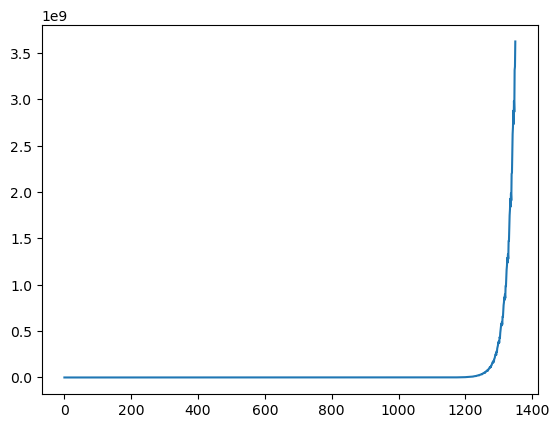

In [32]:
plt.plot(series_1)

In [34]:
series_1

[8.7,
 12.6,
 10.9,
 8.7,
 9.3,
 6.3,
 7.8,
 10.0,
 11.0,
 11.1,
 12.6,
 10.2,
 11.1,
 8.7,
 9.5,
 9.7,
 8.2,
 5.0,
 6.5,
 12.1,
 8.9,
 6.1,
 2.8,
 3.7,
 6.8,
 6.6,
 7.0,
 7.3,
 7.9,
 10.6,
 8.1,
 6.7,
 8.0,
 10.0,
 6.7,
 9.4,
 9.3,
 6.0,
 5.8,
 4.9,
 5.0,
 8.4,
 12.3,
 13.0,
 11.4,
 6.8,
 7.6,
 12.4,
 7.1,
 7.5,
 10.0,
 5.3,
 6.3,
 8.0,
 8.3,
 9.3,
 9.5,
 5.6,
 7.0,
 8.5,
 8.5,
 8.2,
 8.5,
 9.6,
 9.7,
 7.1,
 8.4,
 9.2,
 9.8,
 8.1,
 9.4,
 10.0,
 5.1,
 6.7,
 6.9,
 6.8,
 8.6,
 9.1,
 3.9,
 4.8,
 8.4,
 11.6,
 12.1,
 12.4,
 10.0,
 10.1,
 9.7,
 11.7,
 7.9,
 8.6,
 7.7,
 5.8,
 8.7,
 10.6,
 6.7,
 8.8,
 9.7,
 9.0,
 11.8,
 15.2,
 10.0,
 10.5,
 5.5,
 9.4,
 8.8,
 5.3,
 13.0,
 15.2,
 13.2,
 11.5,
 6.8,
 4.7,
 5.2,
 6.8,
 10.7,
 10.1,
 10.0,
 9.8,
 5.5,
 13.5,
 16.6,
 8.4,
 8.2,
 11.1,
 10.8,
 8.8,
 10.8,
 8.7,
 12.4,
 9.0,
 13.5,
 14.7,
 10.9,
 8.5,
 6.0,
 12.7,
 11.1,
 8.7,
 12.3,
 13.3,
 5.6,
 13.7,
 8.5,
 11.2,
 8.7,
 11.7,
 12.5,
 8.2,
 15.6,
 10.3,
 11.4,
 9.7,
 6.3,
 14.3,
 11.3,
 7.3,
 12.8,


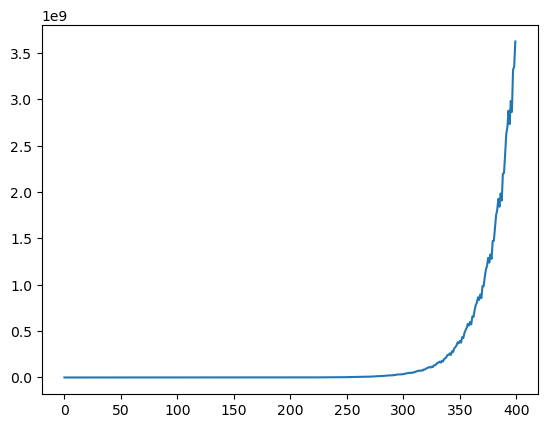

In [33]:
plt.plot(forecast_future_1)

In [195]:
# forecast = []

# # Use the model to predict data points per window size
# #model.predict(series[]
# for i in range(len(series_1) - window_size):
#       forecast.append(model_1.predict(series_1[i:i + window_size][np.newaxis]))
#   #print(i,model.predict(series[i:i + window_size][np.newaxis]))
# len(forecast)
# # Slice the points that are aligned with the validation set
# # forecast = forecast[shp_i+1 - window_size:]

# # Compare number of elements in the predictions and the validation set
# #print(f'length of the forecast list: {len(forecast)}')
# #print(f'shape of the validation set: {x_valid.shape}')
# print(len(forecast))

In [86]:
# forecast_future = []

# i=shp[0] -window_size

# for k in range(5):
    
#     forecast_future.append(model.predict(series_1[i:i + window_size][np.newaxis]))
#     print(forecast_future)
#     i +=1
# new_value = forecast_future[-1]
#     #model.predict(series[i:i + window_size][np.newaxis])
# print(new_value)
# series_1 = list(series_1)
# series_1.append(float(new_value))
# series_1 = np.array(series_1)
    

In [87]:

# i=len(series_1) -window_size
# for k in range(10):
#     forecast_future = []
#     for m in range(1):

#         forecast_future.append(model_1.predict(series_1[i:i + window_size][np.newaxis]))
#     i+=1
#     new_value = forecast_future[-1]
#     #model.predict(series[i:i + window_size][np.newaxis])
#     print(new_value)
#     series_1 = list(series_1)
#     series_1.append(float(new_value))
#     print("len of series :",len(series_1))
#     series_1 = np.array(series_1)
#     #comp_data = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
#     #model.fit(comp_data,epochs=500)

In [196]:
results = np.array(forecast).squeeze()

In [213]:
# plt.figure(figsize=(12,8))
# plt.plot(results)
# plt.plot(series_1[:])
# # plt.xlim([0,len(df)+200])
# plt.ylim([0,50])
# plt.show()

1/1 [==============================] - 0s 23ms/step


array([[12.387826]], dtype=float32)

In [205]:
forecast_future_1 = []
series_1 = list(series_1)
for i in range(400):
    forecast_future_1.append(float(model_1.predict(np.array(series_2)[i:i+window_size][np.newaxis])[0][0]))
    series_1.append(float(model_1.predict(np.array(series_2)[i:i+window_size][np.newaxis])[0][0]))
    series_2.append(float(model_1.predict(np.array(series_2)[i:i+window_size][np.newaxis])[0][0]))



1/1 [==============================] - 0s 16ms/step


In [113]:
# i=len(series_1) -window_size
# forecast_future_1 = []
# for k in range(200):
    
#     for m in range(1):

#         forecast_future_1.append(model_1.predict(series_1[i:i + window_size][np.newaxis]))
#     i+=1
#     new_value_1 = forecast_future_1[-1]

#     print(new_value_1)
#     series_1 = list(series_1)
#     series_1.append(float(new_value_1))
#     print("len of series :",len(series_1))
#     series_1 = np.array(series_1)
    

In [120]:

# initializing date
# test_date_end = datetime.datetime.strptime(str(df_wdstrm_p1new.index[-1].date()), "%Y-%m-%d")
# #forecast_date_end = datetime.datetime.strptime(str(df_wdstrm_p1new.index[-1].date().replace(year=2023)), "%Y-%m-%d")
# forecast_date_end = datetime.datetime.strptime(('2024-01-01'), "%Y-%m-%d")


# # initializing K
# #K = 5
 
# date_generated = pd.date_range(test_date_end, forecast_date_end, freq = "m" )
# #print(date_generated.strftime("%Y-%m-%d"))
# date_generated

DatetimeIndex(['2022-11-30', '2022-12-31', '2023-01-31', '2023-02-28',
               '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30',
               '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31',
               '2023-11-30', '2023-12-31'],
              dtype='datetime64[ns]', freq='M')

In [121]:
# forecast_period = (pd.DataFrame(date_generated, columns = ['date']))
# forecast_period = forecast_period[:]

# #forecast_period = forecast_period.set_index('date').reset_index()
# dates = []
# for i in forecast_period['date']:
#     a = (i.date().replace(day=1))#.replace(day=1)
#     dates.append(a)
    
    


In [55]:
# forecast_period= pd.DataFrame(dates[-12:], columns =['date'])
# forecast_period

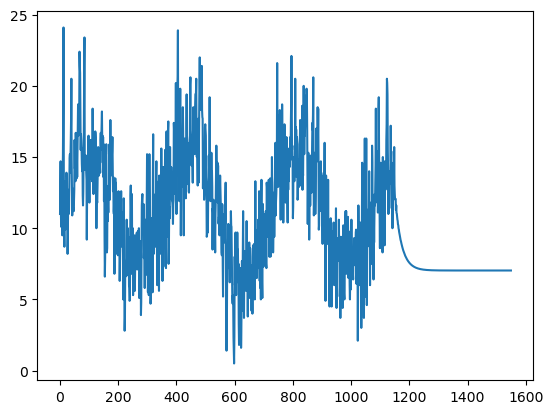

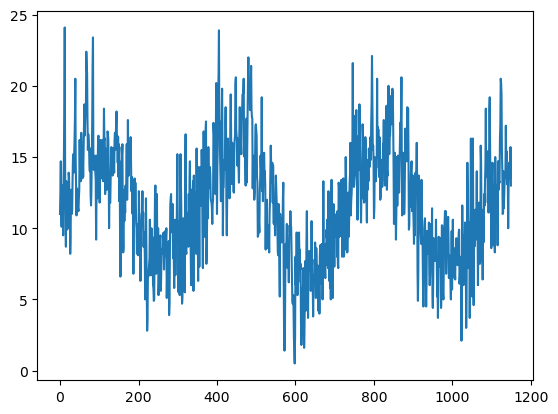

In [156]:
plt.plot(series_1)

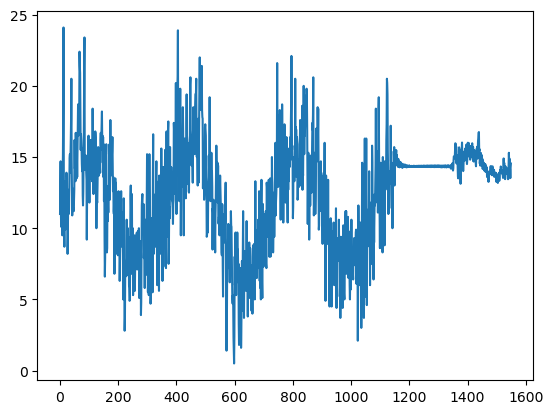

In [183]:
plt.plot(series_1)
# plt.plot(forecast_future_1)

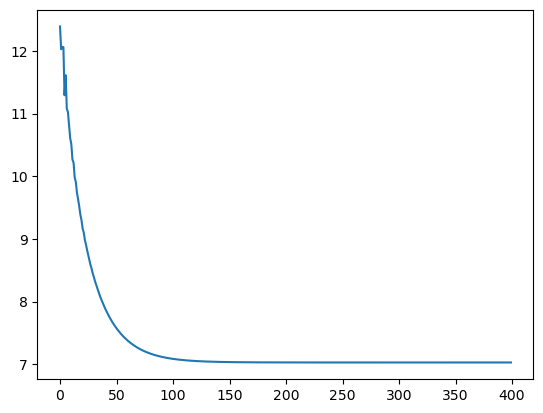

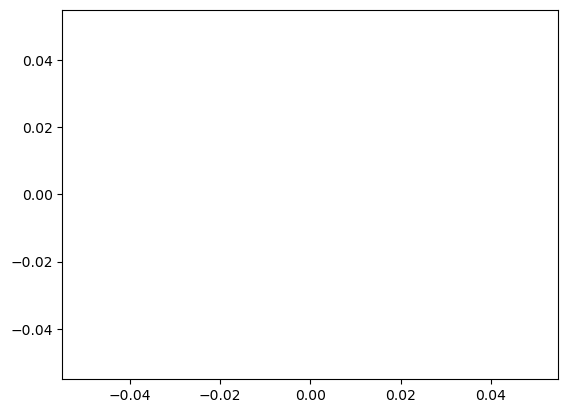

In [159]:
plt.plot(forecast_future_1)